# Attack DPA Contest v2 with CPA and DPA

In this guide, we will show how to attack the DPA V2 trace set with CPA and DPA method, with the help of the `scared` library.

## The DPA V2 trace set

For this example, we will use the [DPA Contest v2](http://www.dpacontest.org/v2/download.php). In the second version, they provide different sets of power measurement traces acquired from the [SASEBO-GII](http://satoh.cs.uec.ac.jp/SASEBO/en/board/sasebo-g2.html) platform performing AES-128 encryptions.

In particular, you must download the raw traces of the public database DPA_contest2_public_base_diff_vcc_a128_2009_12_23.tar.bz2 archive.

Let's assume we have a part of 20 000 traces of this database ready to use in the folder `dpa_v2_files/`. We will now create a `TraceHeaderSet` to study and analyse the trace set.

In [7]:
!pip install matplotlib

  Using cached https://files.pythonhosted.org/packages/19/7a/60bd79c5d79559150f8bba866dd7d434f0a170312e4d15e8aefa5faba294/matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/11/fa/0160cd525c62d7abd076a070ff02b2b94de589f1a9789774f17d7c54058e/pyparsing-2.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/f8/518fb0bb89860eea6ff1b96483fbd9236d5ee991485d0f3eceff1770f654/kiwisolver-1.1.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl


In [1]:
import scared

For binary files, we need to specify how to build trace set metadata to the traces reader, as a dict:

In [2]:
metadata = {
    'key': scared.traces.bin_extractor.PatternExtractor(r"([A-Fa-f0-9]{32})", num=0),
    'plain': scared.traces.bin_extractor.PatternExtractor(r"([A-Fa-f0-9]{32})", num=1),
    'cipher': scared.traces.bin_extractor.PatternExtractor(r"([A-Fa-f0-9]{32})", num=2)
}

Then we create the trace set:

In [5]:
ths = scared.traces.read_ths_from_bin_filenames_pattern(
    '../../../../dpa_v2_files/*.bin',
    dtype='int16',
    metadatas_parsers=metadata
)
print(ths)

# Trace Header Set:
# Name.............: BinFormat trace header set
# Reader...........: Bin format reader with 20000 files, dtype int16
# key..............: uint8
# plain............: uint8
# cipher...........: uint8

Trace Header Set:
Name.............: BinFormat trace header set
Reader...........: Bin format reader with 20000 files, dtype int16
key..............: uint8
plain............: uint8
cipher...........: uint8



We can now study the traces. Here, the set contains 20 000 traces, with the same known key for all the traces, and plain and cipher for each trace.

In [8]:
import matplotlib.pyplot as plt

Prior to seting up the attack, let's try to focus on the right trace zone. Here, as we have the (plain, cipher) pairs together with the overall encryption measurement, we can try to target the first (yellow) and/or the last AES round (red).

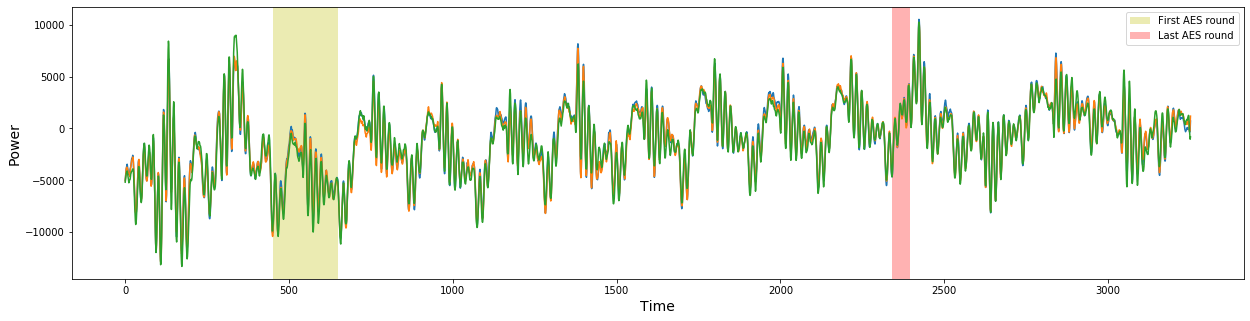

In [11]:
plt.rcParams['figure.figsize']=(21, 5)
data = ths.samples[0:3]
plt.xlabel('Time', fontsize=14)
plt.ylabel('Power', fontsize=14)
plt.plot(data.T)
plt.axvspan(450, 650 , facecolor='y', alpha=0.3, label='First AES round')
plt.axvspan(2340, 2395 , facecolor='r', alpha=0.3, label='Last AES round')
plt.legend()

---

## Attack the first round with CPA

Here, we will proceed to an attack on the first AES round, with CPA method.
First, we need to define the selection function to be used for intermediate values computation:

In [15]:
import numpy as np
from scared import aes

# The attack selection function takes the targeted meta and guesses as arguments, and returns the intermediate values.
# Here we target the first add round key output of the first aes round.
@scared.attack_selection_function
def first_add_key(plain, guesses):
    res = np.empty((plain.shape[0], len(guesses), plain.shape[1]), dtype='uint8')
    for i, guess in enumerate(guesses):
        res[:, i, :] = np.bitwise_xor(plain, guess)
    return res

Second, we can create the CAP attack object, passing it our selection function, a leakage model, and a discriminant function to compute key candidates scores.

In [19]:
cpa_attack = scared.CPAAttack(
    selection_function=first_add_key,
    model=scared.HammingWeight(),
    discriminant=scared.maxabs
)

Before running the attack, we finally need to wrap our `TraceHeaderSet` with a trace container, specifiying the analysis frame to use:

In [17]:
first_round_container = scared.Container(ths[:10000], frame=slice(450, 650))

We can then proceed to the attack run:

In [20]:
cpa_attack.run(first_round_container)

We can check the obtained best key candidate, and compare it to the expected first round:

In [28]:
cpa_first_round_key = np.argmax(cpa_attack.scores, axis=0)
expected_first_round_key = aes.key_schedule(key=ths[0].key)[1]
np.array_equal(expected_first_round_key, cpa_first_round_key)
# False

False

No luck, this attack doesn't retrieve the good key. Let's now try to target the two last rounds of the AES.

## Attack the last rounds with CPA

We first have to define the corresponding selection function for the delta R between last two rounds.

In [22]:
@scared.attack_selection_function
def delta_last_two_rounds(cipher, guesses):
    res = np.empty((cipher.shape[0], len(guesses), cipher.shape[1]), dtype='uint8')
    for i, guess in enumerate(guesses):
        s = aes.inv_sub_bytes(state=np.bitwise_xor(cipher, guess))
        res[:, i, :] = np.bitwise_xor(aes.shift_rows(cipher), s)
    return res

We define a new container to target the last two rounds of the trace set:

In [23]:
last_rounds_container = scared.Container(ths[:15000], frame=slice(2340, 2395))

We can now create our new CPA analysis. Additionnaly, we use a 500 convergence step, so that we will be able to see how the result depends on the number of traces processed.

In [24]:
cpa_attack = scared.CPAAttack(
    selection_function=delta_last_two_rounds,
    model=scared.HammingWeight(),
    discriminant=scared.maxabs,
    convergence_step=1000
)

Let's run the analysis on our container:

In [25]:
cpa_attack.run(last_rounds_container)

We can now retrieve the best last round key candidate, and compare it to the expected key:

In [29]:
expected_last_key = aes.key_schedule(key=ths[0].key)[-1]
cpa_last_key = np.argmax(cpa_attack.scores, axis=0)
np.array_equal(expected_last_key, cpa_last_key)
# True

True

Success! The correct last key is retrieved. To finish, we have the ability to study the CPA traces and convergence scores evolution. Let's plot them for the byte 15 of the key:

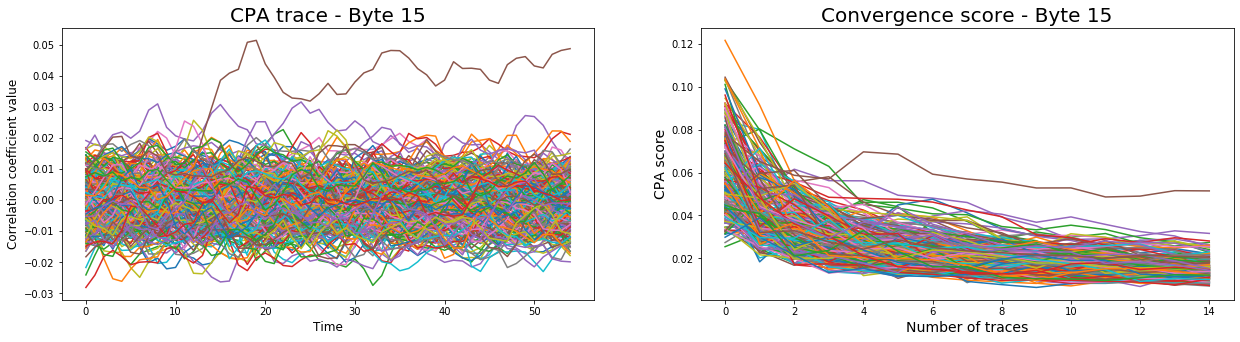

In [31]:
plt.subplot(121)
plt.title('CPA trace - Byte 15', fontsize=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Correlation coefficient value', fontsize=12)
plt.plot(cpa_attack.results[:, 15, :].T)

# Plotting the convergence scores for byte 15
plt.subplot(122)
plt.title('Convergence score - Byte 15', fontsize=20)
plt.xlabel('Number of traces', fontsize=14)
plt.ylabel('CPA score', fontsize=14)
plt.plot(cpa_attack.convergence_traces[:, 15,:].T)
plt.show()

The best candidate value for this byte is clearly identified, both in correlation traces and convergence traces.
Can we now make the same analysis with DPA method ?

---

## Attack the last round with DPA

We will proceed to the same analysis than before on the last two rounds, but this time with DPA method.
First, we will use a monobit leakage model on the bit 7:

In [32]:
dpa_attack = scared.DPAAttack(
    selection_function=delta_last_two_rounds,
    model=scared.Monobit(7),
    discriminant=scared.maxabs
)

We can run the attack:

In [33]:
dpa_attack.run(last_rounds_container)

Let's see the obtained key, and compare it to the expected one:

In [34]:
dpa_key = np.argmax(dpa_attack.scores, axis=0)
print(dpa_key)
print(expected_last_key)
# [148 159 123 136 216 184 196  54 116  90  36  95 239 133 192 225]
# [ 83 159 177 136  64 126  43  63  45  90  36  95  80 254 190 225]

[148 159 123 136 216 184 196  54 116  90  36  95 239 133 192 225]
[ 83 159 177 136  64 126  43  63  45  90  36  95  80 254 190 225]


As we can see, targeting the last bit does not allow us to recover the whole key bytes. Let's try attacking the other bits to retrieve the whole key.

In [35]:
# Let's keep record of the max DPA scores.
max_scores = np.copy(dpa_attack.scores)

for b in range(7):
    print("Bit ", b)
    dpa_analysis = scared.DPAAttack(
        selection_function=delta_last_two_rounds,
        model=scared.Monobit(b),
        discriminant=scared.maxabs
    )
    dpa_analysis.run(last_rounds_container)
    max_scores = np.maximum(max_scores, dpa_analysis.scores)

Bit  0
Bit  1
Bit  2
Bit  3
Bit  4
Bit  5
Bit  6


Now, let's see if we can retrieve all the key bytes:

In [36]:
last_key = np.argmax(max_scores, axis=0)
np.array_equal(last_key, expected_last_key)
# True

True

Success! We have retrieve the whole key.